In [2]:
!pip install torchinfo

### Import Libraries

In [3]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

### Configuration

In [4]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [5]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [14]:
data_dir = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: brain_tumor, Count: 5000
Class: brain_menin, Count: 5000
Class: brain_glioma, Count: 5000


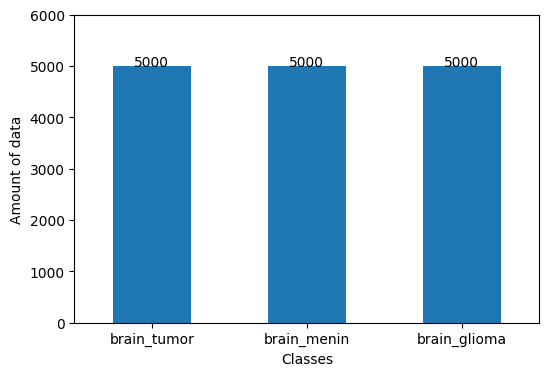

In [15]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

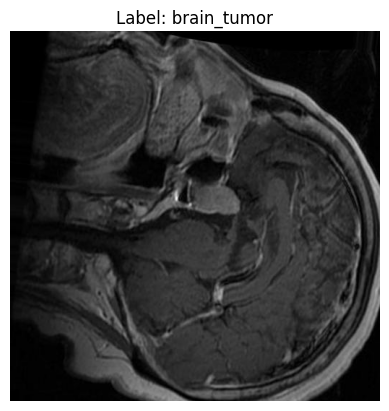

In [16]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [18]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [19]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  10500
Validation Data:  2250
Test Data:  2250
-------------------------------------------
Total amounts of data in the dataset:  15000


In [20]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class           Count
------------  -------
brain_tumor      3500
brain_menin      3500
brain_glioma     3500

Validation Dataset
Class           Count
------------  -------
brain_glioma      750
brain_menin       750
brain_tumor       750

Test Dataset
Class           Count
------------  -------
brain_tumor       750
brain_menin       750
brain_glioma      750


### Device Variable

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Checkpoint

In [23]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [24]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [25]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [26]:
total_class = 3
learning_rate = 0.0001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.6MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

### Training

In [32]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 395759 KiB |   2980 MiB |   2068 GiB |   2068 GiB |
|       from large pool | 325056 KiB |   2928 MiB |   2059 GiB |   2058 GiB |
|       from small pool |  70703 KiB |     86 MiB |      9 GiB |      9 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 395759 KiB |   2980 MiB |   2068 GiB |   2068 GiB |
|       from large pool | 325056 KiB |   2928 MiB |   2059 GiB |

In [3]:
import time


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Send model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example DataLoaders (must be defined)
dataloader_train_dataset = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"
dataloader_valid_dataset = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer"

save_path_checkpoints = "./checkpoints"


In [7]:
from tqdm import tqdm


In [9]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === 1️⃣ Create image transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === 2️⃣ Load datasets ===
train_dataset = datasets.ImageFolder(root="/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer", transform=transform)
valid_dataset = datasets.ImageFolder(root="/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer", transform=transform)

dataloader_train_dataset = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# === 3️⃣ Define model ===
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Adjust for your number of classes
model.to(device)

# === 4️⃣ Loss and optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === 5️⃣ Make checkpoints folder ===
save_path_checkpoints = "./checkpoints"
os.makedirs(save_path_checkpoints, exist_ok=True)

# === 6️⃣ Define train_model function ===
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f'Training Loss: {epoch_train_loss:.3f} Acc: {epoch_train_acc:.3f}')

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Validation Loss: {epoch_val_loss:.3f} Acc: {epoch_val_acc:.3f}')

        # Early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping triggered. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# === 7️⃣ Run training ===
start_time = time.time()

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

# === 8️⃣ Save training history ===
data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('./training_data.xlsx', index=False)
print("Training history saved to training_data.xlsx")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 469/469 [03:26<00:00,  2.27it/s, acc=0.841, loss=0.401]


Training Loss: 0.401 Acc: 0.841
Validation Loss: 1.076 Acc: 0.657
Best model saved at epoch 1 with validation accuracy: 0.657


Epoch 2/20: 100%|██████████| 469/469 [02:00<00:00,  3.89it/s, acc=0.919, loss=0.22] 


Training Loss: 0.220 Acc: 0.919
Validation Loss: 1.221 Acc: 0.679
Best model saved at epoch 2 with validation accuracy: 0.679


Epoch 3/20: 100%|██████████| 469/469 [02:21<00:00,  3.31it/s, acc=0.947, loss=0.142]


Training Loss: 0.142 Acc: 0.947
Validation Loss: 0.299 Acc: 0.901
Best model saved at epoch 3 with validation accuracy: 0.901


Epoch 4/20: 100%|██████████| 469/469 [02:00<00:00,  3.90it/s, acc=0.962, loss=0.106]


Training Loss: 0.106 Acc: 0.962
Validation Loss: 0.300 Acc: 0.917
Best model saved at epoch 4 with validation accuracy: 0.917


Epoch 5/20: 100%|██████████| 469/469 [02:00<00:00,  3.89it/s, acc=0.971, loss=0.0791]


Training Loss: 0.079 Acc: 0.971
Validation Loss: 0.337 Acc: 0.908
Early stopping triggered. Training stopped.
Training Time: 1183.75 seconds ---> 19.73 minutes
Training history saved to training_data.xlsx


In [11]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [13]:
import matplotlib.pyplot as plt


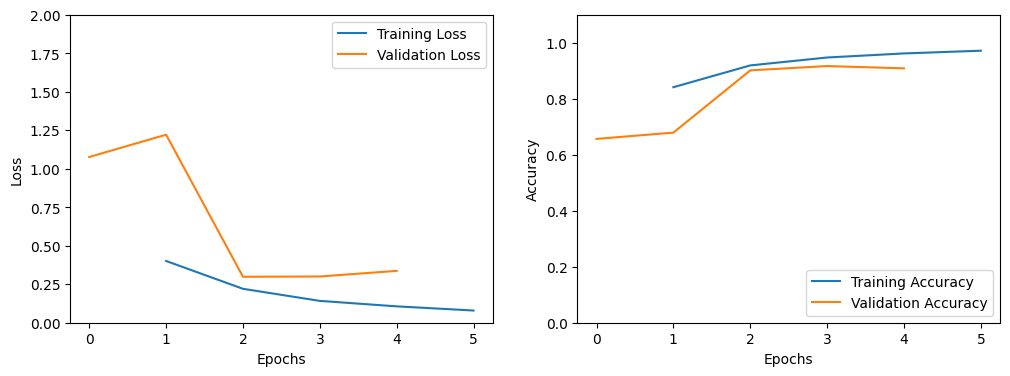

In [14]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [15]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [16]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 4) - Validation Loss: 0.300, Validation Accuracy: 0.917


In [17]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

NameError: name 'dataloader_test_dataset' is not defined

In [18]:
import time

# Define test dataset
test_dataset = datasets.ImageFolder(root="/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer", transform=transform)
dataloader_test_dataset = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")


Test Loss: 0.300 | Test Accuracy: 0.917
Test Time: 92.34 seconds ---> 1.54 minutes


In [20]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np

In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

NameError: name 'total_class' is not defined

In [23]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Determine number of classes based on model output or dataset labels
# Option 1: based on dataset
# all_labels = [label.item() for _, labels in dataloader_test_dataset for label in labels]
# total_class = len(set(all_labels))

# Option 2: based on model output
sample_input, _ = next(iter(dataloader_test_dataset))
sample_output = model(sample_input.to(device))
total_class = sample_output.shape[1]

def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy

# Gather predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute and display per-class accuracy
class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      5000
           1       0.86      0.95      0.90      5000
           2       0.92      0.95      0.93      5000

    accuracy                           0.92     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.92      0.92      0.92     15000

Class 0 Accuracy: 0.850
Class 1 Accuracy: 0.953
Class 2 Accuracy: 0.947
